# Visualizing Extracted Angle Sequences

This notebook demonstrates the angle sequences extracted from push-up videos using `PoseFeatureExtractor`.

The extracted angles are:
1. **Left Elbow Angle** (wrist-elbow-shoulder)
2. **Right Elbow Angle** (wrist-elbow-shoulder)
3. **Left Shoulder Angle** (elbow-shoulder-hip)
4. **Right Shoulder Angle** (elbow-shoulder-hip)
5. **Left Body Angle** (shoulder-hip-knee)
6. **Right Body Angle** (shoulder-hip-knee)

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from feature_engineering.pose_feature_extractor import PoseExtractionResult

In [2]:
CACHE_DIR = ".feature_cache"

ANGLE_NAMES = [
    "Left Elbow",
    "Right Elbow",
    "Left Shoulder",
    "Right Shoulder",
    "Left Body (Hip)",
    "Right Body (Hip)"
]

## Helper Functions

In [3]:
from feature_engineering.density_map import SCALE_FACTOR
def load_features(file_path: str) -> tuple:
    """Load features from cache file and extract common metadata.
    
    Returns:
        Tuple of (features, angles, density_map, filename, label)
    """
    features: PoseExtractionResult = torch.load(file_path, weights_only=False)
    angles = features.angle_sequence
    density_map = features.density_map
    filename = os.path.basename(file_path)
    label = filename.split('_')[0]
    return features, angles, density_map, filename, label


def get_axis(axes, idx: int, total: int):
    """Get the correct axis from subplot axes array.
    
    Handles the case where there's only one subplot (axes is not an array).
    """
    return axes[idx] if total > 1 else axes


def plot_density_with_elbow(ax, frames, angles, density_map, title: str):
    """Plot elbow angles and density map on twin axes.
    
    Args:
        ax: Primary matplotlib axis
        frames: Array of frame indices
        angles: Tensor of angle values
        density_map: Tensor of density values
        title: Title for the plot
    """
    ax2 = ax.twinx()
    
    # Plot elbow angles (average of left and right)
    avg_elbow = (angles[:, 0] + angles[:, 1]) / 2
    ax.plot(frames, avg_elbow.numpy(), label='Avg Elbow Angle', 
            color='steelblue', linewidth=1.5, alpha=0.7)
    
    # Plot density map as filled area
    # Divide by the scale_factor to visualise the original
    # density map
    density_map /= SCALE_FACTOR
    ax2.fill_between(frames, density_map.numpy(), alpha=0.4, 
                     color='orange', label='Density Map')
    ax2.plot(frames, density_map.numpy(), color='darkorange', 
             linewidth=1.5, alpha=0.8)
    
    ax.set_xlabel('Frame')
    ax.set_ylabel('Elbow Angle (normalized)', color='steelblue')
    ax2.set_ylabel('Density', color='darkorange')
    ax.set_title(title)
    ax.tick_params(axis='y', labelcolor='steelblue')
    ax2.tick_params(axis='y', labelcolor='darkorange')
    ax.grid(True, alpha=0.3)
    ax2.set_ylim(0, 0.2)
    
    # Combined legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

## Load Cached Angle Sequences

In [4]:
cache_files = sorted(glob.glob(os.path.join(CACHE_DIR, "*.pt")))

files_by_label = {}
for f in cache_files:
    filename = os.path.basename(f)
    label = int(filename.split('_')[0])
    if label not in files_by_label:
        files_by_label[label] = []
    files_by_label[label].append(f)

print("Available labels and counts:")
for label in sorted(files_by_label.keys()):
    print(f"  Label {label}: {len(files_by_label[label])} videos")

Available labels and counts:
  Label 1: 1 videos
  Label 2: 16 videos
  Label 3: 34 videos
  Label 4: 21 videos
  Label 5: 2 videos
  Label 6: 2 videos
  Label 7: 1 videos


In [5]:
# Select a few sample videos
sample_files = []
for label in sorted(files_by_label.keys())[:4]:
    sample_files.append(files_by_label[label][0])

print("Selected samples:")
for f in sample_files:
    print(f"  {os.path.basename(f)}")

Selected samples:
  1_dksksjfwijf.pt
  2_dfsaeklnvvalkej.pt
  3_asldkfjalwieaskdfaskdf.pt
  4_20251209_Text_to_Video_Generate_a_561_0.pt


## Plot All 6 Angles for Each Sample Video

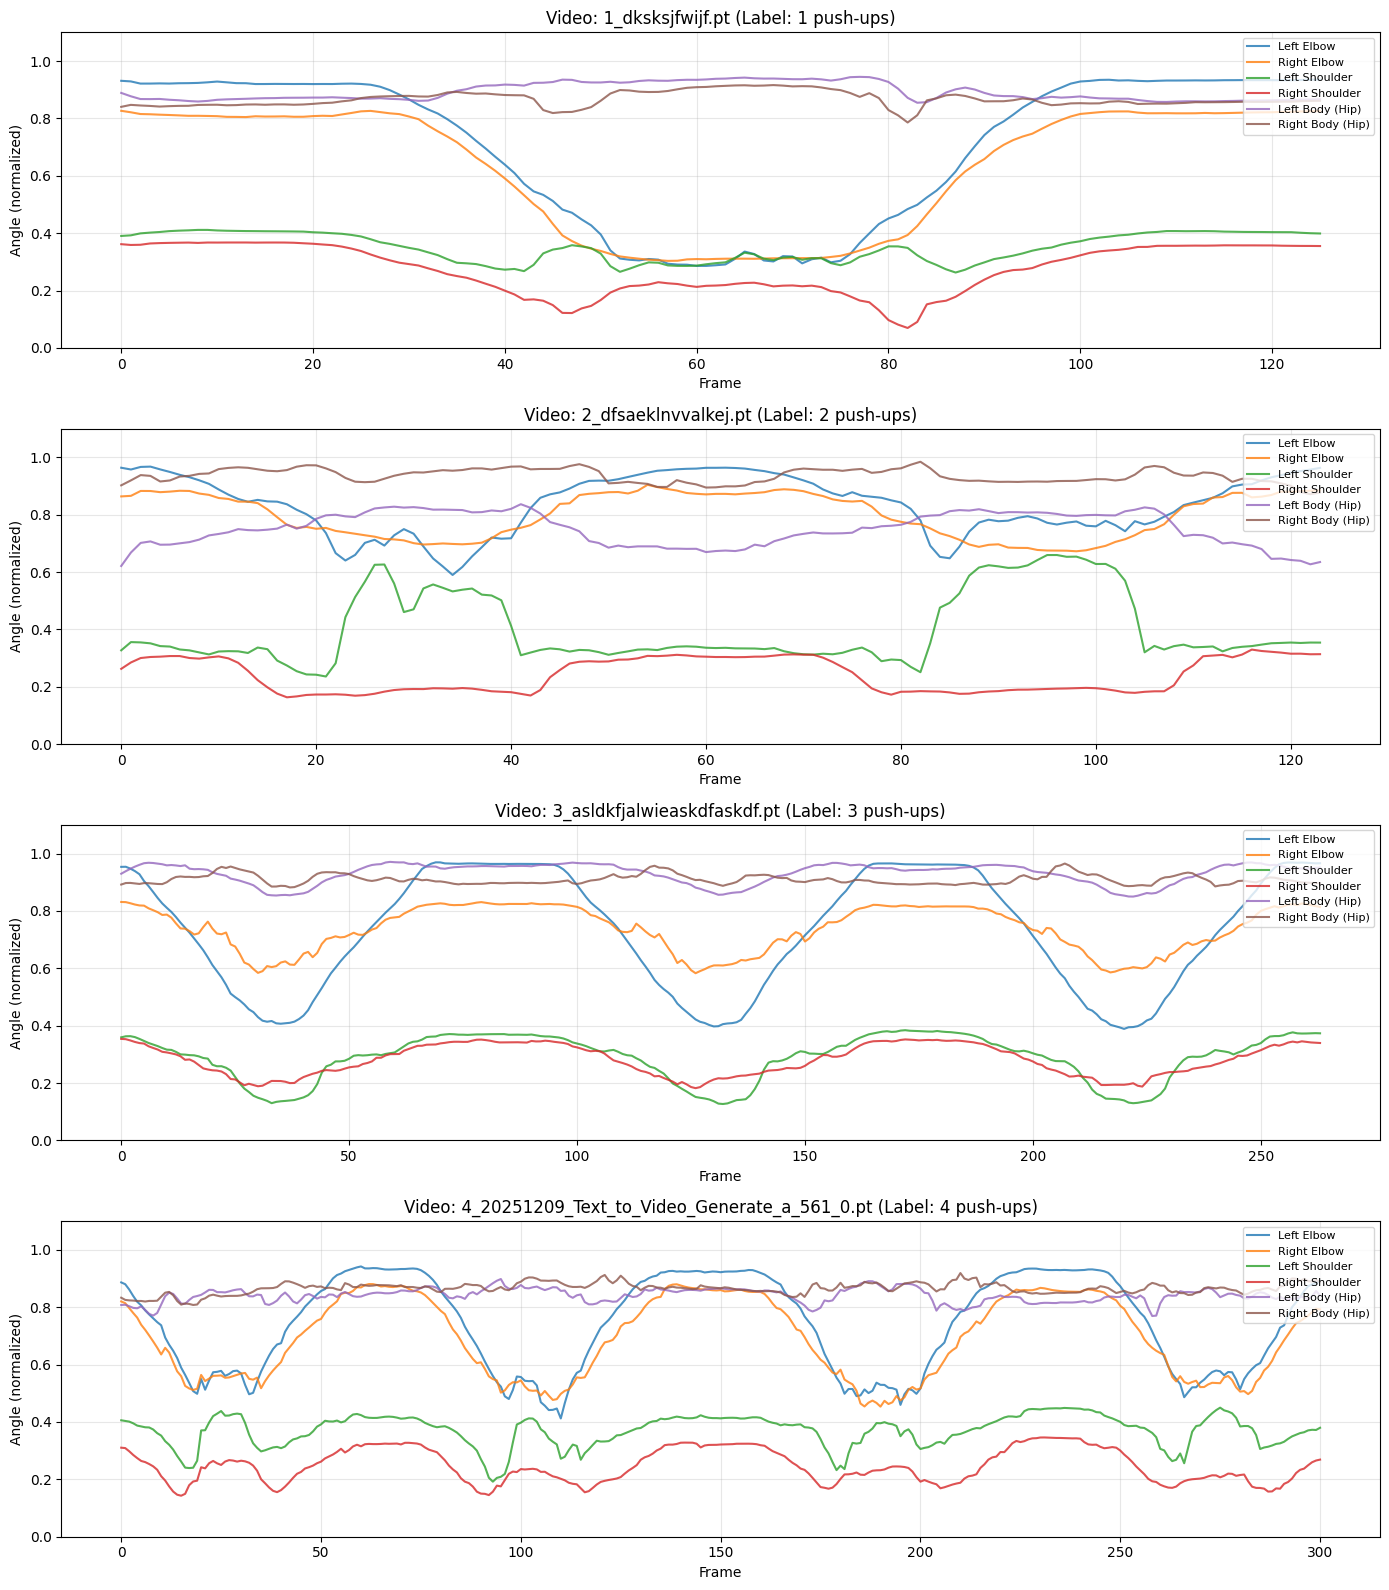

In [6]:
fig, axes = plt.subplots(len(sample_files), 1, figsize=(14, 4 * len(sample_files)))

for idx, file_path in enumerate(sample_files):
    _, angles, _, filename, label = load_features(file_path)
    
    ax = get_axis(axes, idx, len(sample_files))
    frames = np.arange(len(angles))
    
    for i, angle_name in enumerate(ANGLE_NAMES):
        ax.plot(frames, angles[:, i].numpy(), label=angle_name, alpha=0.8)
    
    ax.set_xlabel('Frame')
    ax.set_ylabel('Angle (normalized)')
    ax.set_title(f'Video: {filename} (Label: {label} push-ups)')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

## Focus on Elbow Angles (Most Indicative of Push-up Motion)

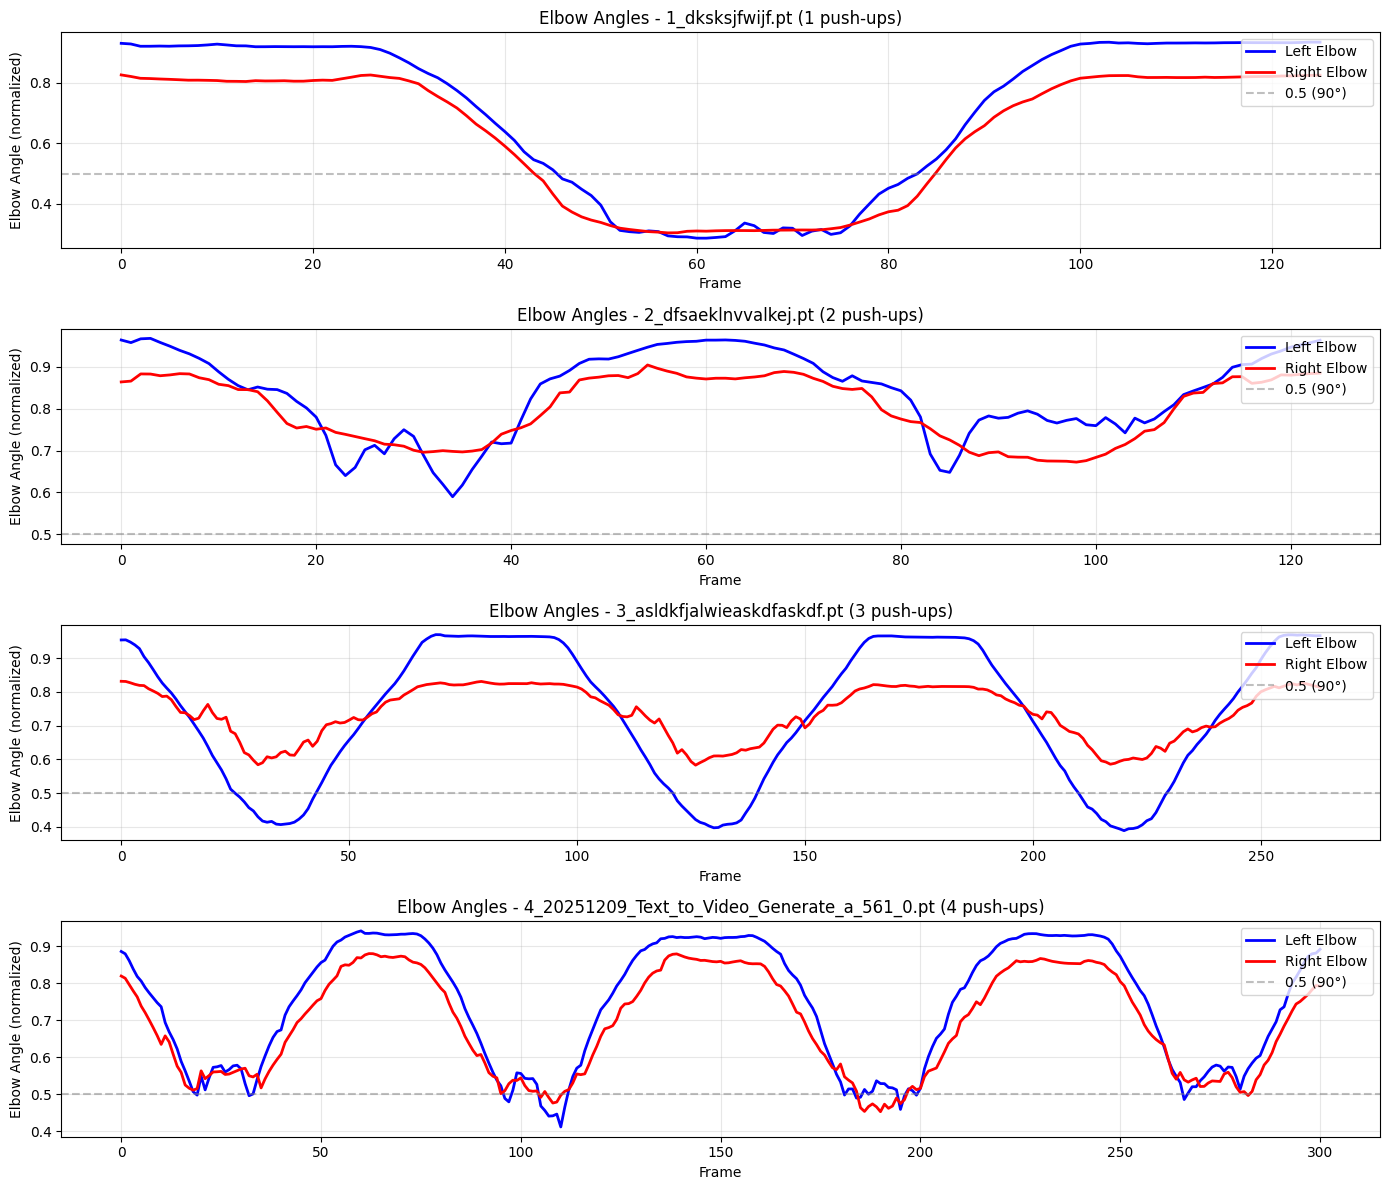

In [7]:
fig, axes = plt.subplots(len(sample_files), 1, figsize=(14, 3 * len(sample_files)))

for idx, file_path in enumerate(sample_files):
    _, angles, _, filename, label = load_features(file_path)
    
    ax = get_axis(axes, idx, len(sample_files))
    frames = np.arange(len(angles))
    
    ax.plot(frames, angles[:, 0].numpy(), label='Left Elbow', color='blue', linewidth=2)
    ax.plot(frames, angles[:, 1].numpy(), label='Right Elbow', color='red', linewidth=2)
    
    # Add horizontal reference lines
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='0.5 (90°)')
    
    ax.set_xlabel('Frame')
    ax.set_ylabel('Elbow Angle (normalized)')
    ax.set_title(f'Elbow Angles - {filename} ({label} push-ups)')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Statistics Summary

In [8]:
for file_path in sample_files:
    _, angles, density_map, filename, label = load_features(file_path)
    
    stats_data = []
    for i, name in enumerate(ANGLE_NAMES):
        angle_data = angles[:, i]
        stats_data.append({
            'Angle Type': name,
            'Mean': angle_data.mean().item(),
            'Std': angle_data.std().item(),
            'Min': angle_data.min().item(),
            'Max': angle_data.max().item()
        })
    
    stats_data.append({
        'Angle Type': 'Density Map',
        'Mean': density_map.mean().item(),
        'Std': density_map.std().item(),
        'Min': density_map.min().item(),
        'Max': density_map.max().item()
    })
    
    df = pd.DataFrame(stats_data)
    df = df.set_index('Angle Type')
    
    print(f"\n{filename} ({label} push-ups) - {len(angles)} frames")
    display(df.round(3))


1_dksksjfwijf.pt (1 push-ups) - 126 frames


,Mean,Std,Min,Max
Angle Type,,,,
Left Elbow,0.701,0.256,0.286,0.935
Right Elbow,0.630,0.215,0.304,0.827
Left Shoulder,0.350,0.049,0.263,0.411
Right Shoulder,0.273,0.084,0.070,0.368
Left Body (Hip),0.892,0.031,0.855,0.945
Right Body (Hip),0.867,0.026,0.786,0.916
Density Map,0.063,0.210,0.000,1.064



2_dfsaeklnvvalkej.pt (2 push-ups) - 124 frames


,Mean,Std,Min,Max
Angle Type,,,,
Left Elbow,0.836,0.101,0.590,0.967
Right Elbow,0.799,0.077,0.672,0.904
Left Shoulder,0.400,0.121,0.236,0.659
Right Shoulder,0.241,0.059,0.164,0.330
Left Body (Hip),0.751,0.057,0.621,0.836
Right Body (Hip),0.936,0.025,0.871,0.984
Density Map,0.129,0.285,0.000,1.064



3_asldkfjalwieaskdfaskdf.pt (3 push-ups) - 264 frames


,Mean,Std,Min,Max
Angle Type,,,,
Left Elbow,0.729,0.204,0.389,0.969
Right Elbow,0.736,0.079,0.583,0.831
Left Shoulder,0.288,0.080,0.127,0.384
Right Shoulder,0.280,0.054,0.182,0.354
Left Body (Hip),0.931,0.035,0.850,0.971
Right Body (Hip),0.909,0.017,0.882,0.965
Density Map,0.091,0.246,0.000,1.064



4_20251209_Text_to_Video_Generate_a_561_0.pt (4 push-ups) - 301 frames


,Mean,Std,Min,Max
Angle Type,,,,
Left Elbow,0.741,0.164,0.412,0.942
Right Elbow,0.690,0.137,0.453,0.881
Left Shoulder,0.370,0.055,0.192,0.450
Right Shoulder,0.247,0.058,0.143,0.346
Left Body (Hip),0.840,0.024,0.769,0.898
Right Body (Hip),0.865,0.019,0.808,0.919
Density Map,0.106,0.262,0.000,1.064


## Density Map Visualization

The density map shows gaussian bumps centered at detected push-up positions (elbow angle valleys).

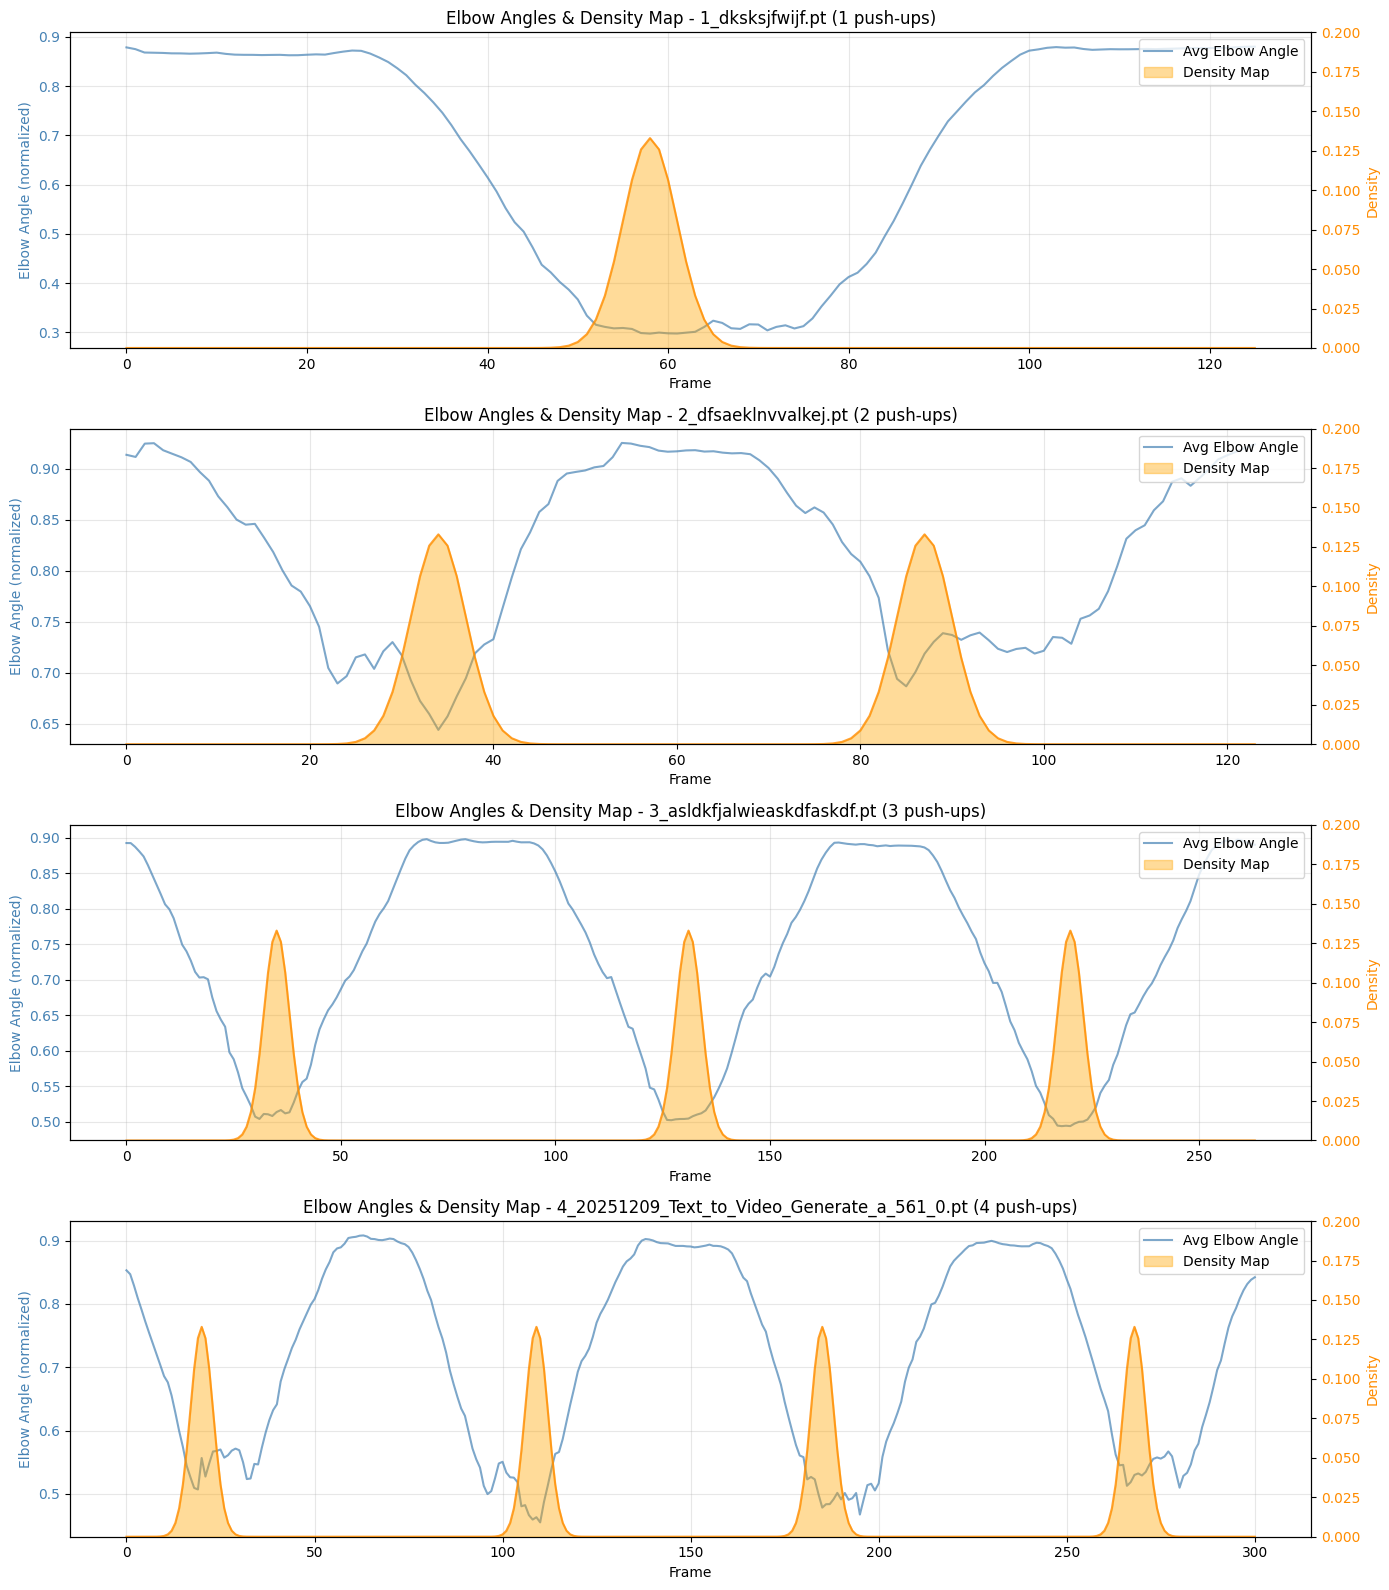

In [9]:
fig, axes = plt.subplots(len(sample_files), 1, figsize=(14, 4 * len(sample_files)))

for idx, file_path in enumerate(sample_files):
    _, angles, density_map, filename, label = load_features(file_path)
    
    ax = get_axis(axes, idx, len(sample_files))
    frames = np.arange(len(angles))
    
    title = f'Elbow Angles & Density Map - {filename} ({label} push-ups)'
    plot_density_with_elbow(ax, frames, angles, density_map, title)

plt.tight_layout()
plt.show()

## Verify Density Map Sums

Check all samples to ensure the sum of the density map matches the labeled push-up count.

In [10]:
mismatches = []
tolerance = 0.1

for file_path in cache_files:
    _, _, density_map, filename, label = load_features(file_path)
    label = int(label)
    
    density_sum = density_map.sum().item()
    diff = abs(density_sum - label)
    
    if diff > tolerance:
        mismatches.append({
            'Filename': filename,
            'Label': label,
            'Density Sum': density_sum,
            'Diff': diff,
            'Path': file_path
        })

df_mismatches = pd.DataFrame(mismatches)
if not df_mismatches.empty:
    print(f"Found {len(mismatches)} samples with density map sum mismatches (tolerance={tolerance}):")
    display(df_mismatches)
else:
    print(f"All {len(cache_files)} samples have density map sums matching their labels (within tolerance {tolerance}).")

Found 77 samples with density map sum mismatches (tolerance=0.1):


,Filename,Label,Density Sum,Diff,Path
0,1_dksksjfwijf.pt,1,8.0,7.0,.feature_cache/1_dksksjfwijf.pt
1,2_dfsaeklnvvalkej.pt,2,16.0,14.0,.feature_cache/2_dfsaeklnvvalkej.pt
2,2_difficult_2.pt,2,16.0,14.0,.feature_cache/2_difficult_2.pt
3,2_difficult_sdafkljsalkfj.pt,2,24.0,22.0,.feature_cache/2_difficult_sdafkljsalkfj.pt
4,2_dkdjwkndkfw.pt,2,16.0,14.0,.feature_cache/2_dkdjwkndkfw.pt
...,...,...,...,...,...
72,5_sadfjhaslfkjasdlkfjsa.pt,5,40.0,35.0,.feature_cache/5_sadfjhaslfkjasdlkfjsa.pt
73,5_sdfkljweoijlkjdsflkjweaij.pt,5,40.0,35.0,.feature_cache/5_sdfkljweoijlkjdsflkjweaij.pt
74,6_dfjewaijsldkjfsaef.pt,6,48.0,42.0,.feature_cache/6_dfjewaijsldkjfsaef.pt
75,6_kling_20251209_Text_to_Video_Generate_a_218_...,6,48.0,42.0,.feature_cache/6_kling_20251209_Text_to_Video_...


## Visualize Mismatch Samples (if any)

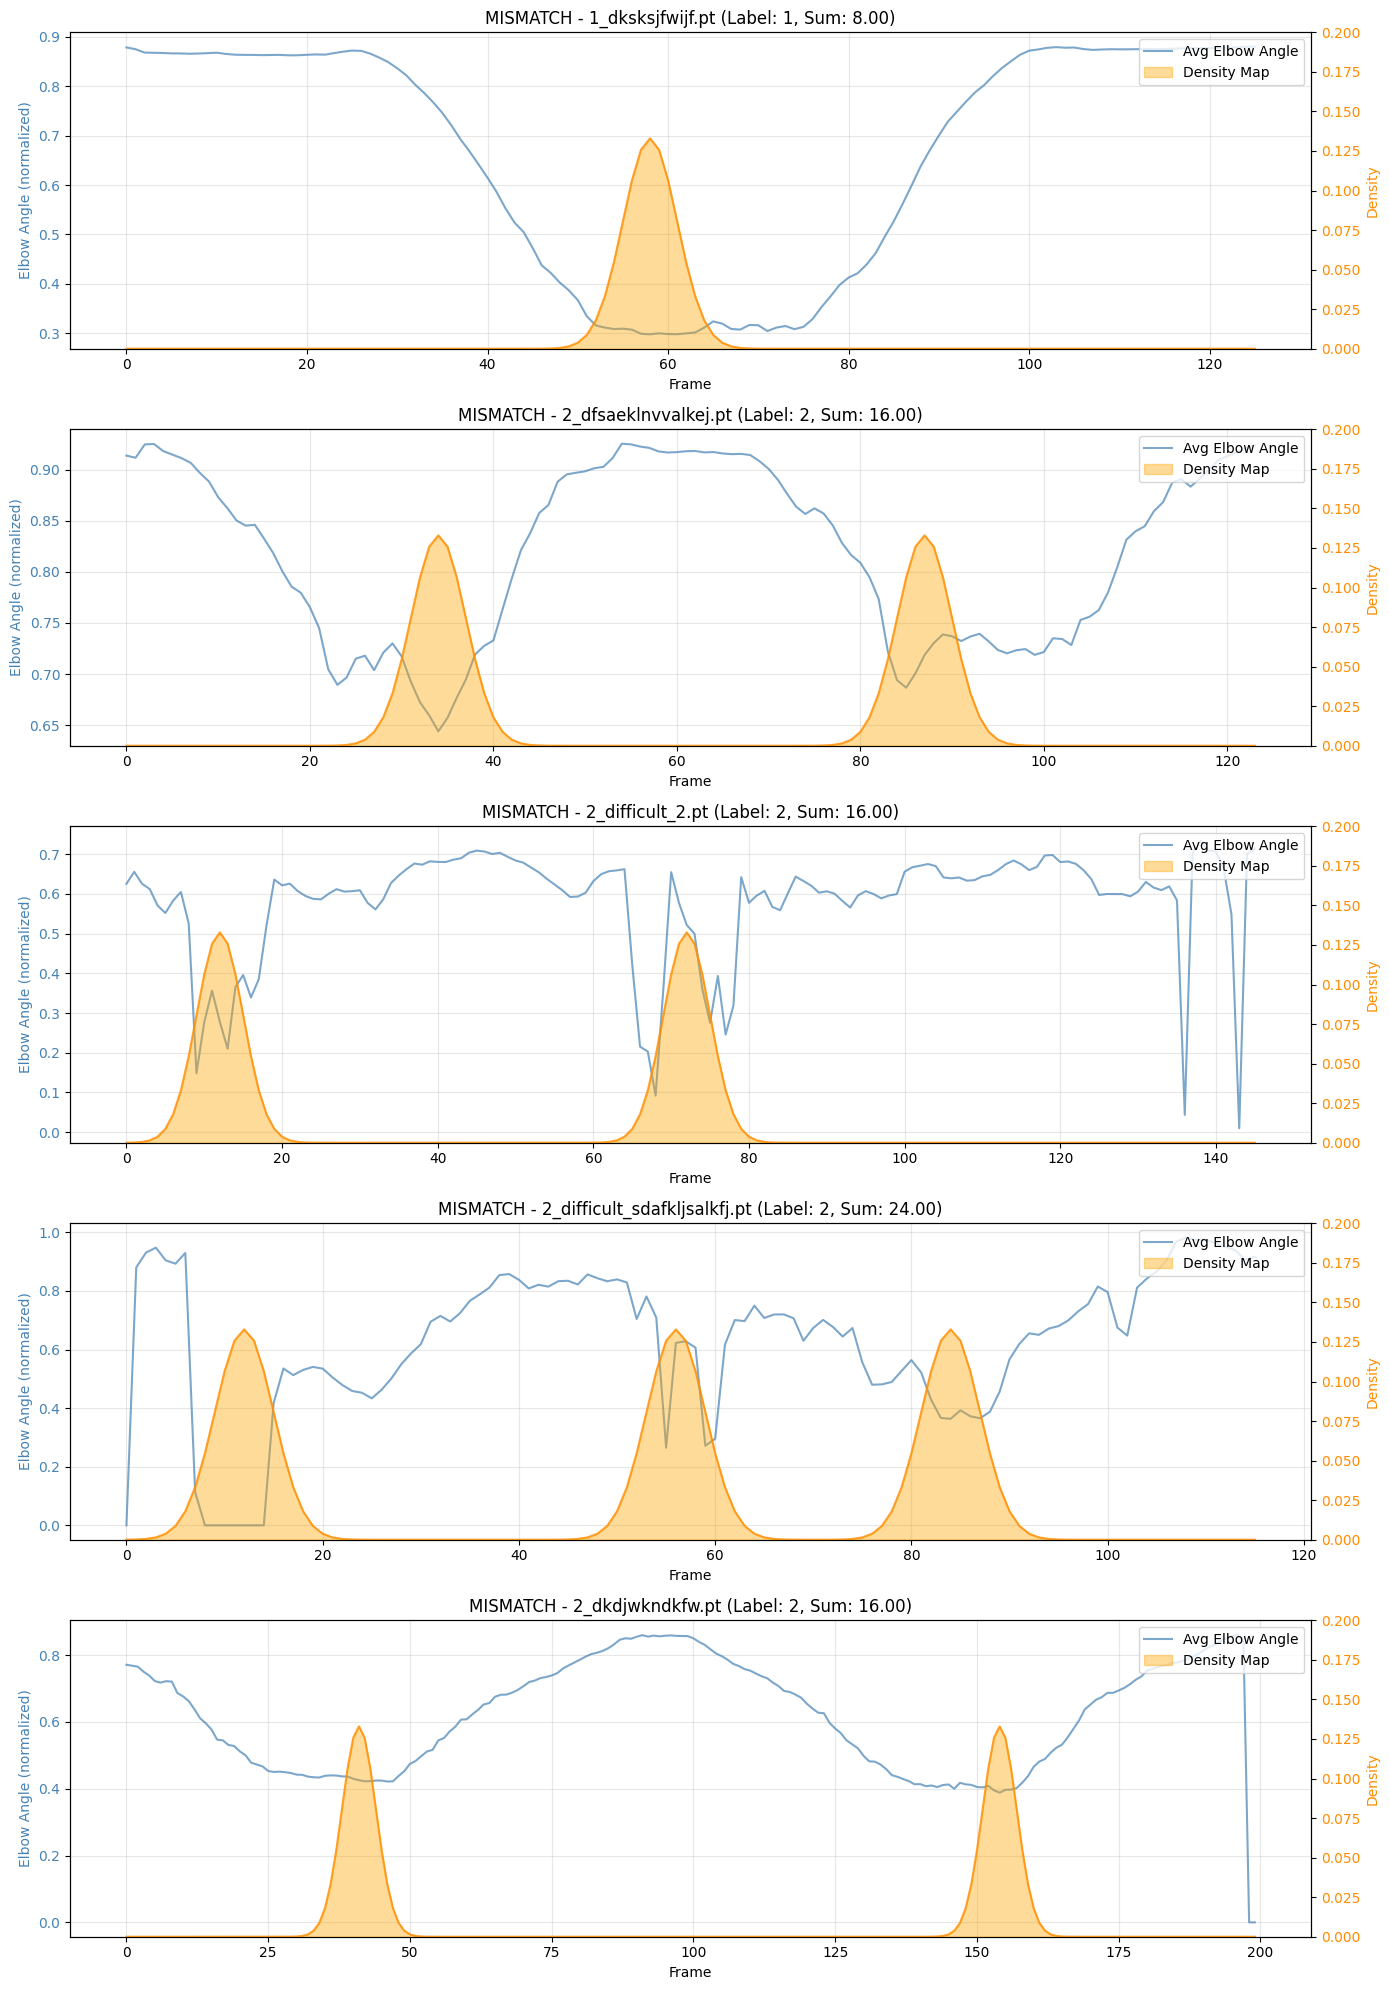

In [11]:
if mismatches:
    # Take up to 5 examples to visualize
    samples_to_plot = mismatches[:5]
    
    fig, axes = plt.subplots(len(samples_to_plot), 1, figsize=(14, 4 * len(samples_to_plot)))
    
    for idx, mismatch in enumerate(samples_to_plot):
        file_path = mismatch['Path']
        _, angles, density_map, filename, _ = load_features(file_path)
        label = mismatch['Label']
        density_sum = mismatch['Density Sum']
        
        ax = get_axis(axes, idx, len(samples_to_plot))
        frames = np.arange(len(angles))
        
        title = f'MISMATCH - {filename} (Label: {label}, Sum: {density_sum:.2f})'
        plot_density_with_elbow(ax, frames, angles, density_map, title)

    plt.tight_layout()
    plt.show()
else:
    print("No mismatches to visualize.")